https://github.com/nobetan/dl_examples/blob/master/tensorflow/tensorflow-mnist-fully-connected-model.ipynb

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from tensorflow.keras.datasets import mnist

np.random.seed(42)

## MNIST データセットを読み込む。

In [2]:
# MNIST データセットを読み込む。
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('x_train.shape: {}, y_train.shape: {}'.format(x_train.shape, y_train.shape))
print('x_test.shape: {}, y_test.shape: {}'.format(x_test.shape, y_test.shape))

x_train.shape: (60000, 28, 28), y_train.shape: (60000,)
x_test.shape: (10000, 28, 28), y_test.shape: (10000,)


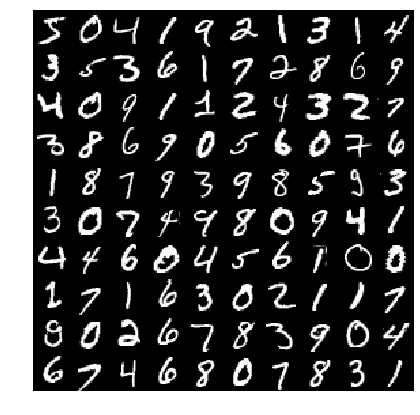

In [3]:
# 最初の100枚を結合して1枚の画像にして、表示する。
first100_imgs = x_train[:100].reshape(10, 10, 28, 28)
merged_img = np.vstack([np.hstack(h_imgs) for h_imgs in first100_imgs])

plt.figure(figsize=(7, 7))
plt.imshow(merged_img, cmap='gray')
plt.axis('off')
plt.show()

## モデルを作成する。

In [4]:
# (N, 28, 28) -> (M, 784) にする。
# 全結合ニューラルネットワークのため、入力は1次元の特徴ベクトルにする必要があるため。
x_train = x_train.reshape(len(x_train), -1)
x_test = x_test.reshape(len(x_test), -1)
print('x_train.shape: {}, x_test.shape: {}'.format(x_train.shape, x_test.shape))

x_train.shape: (60000, 784), x_test.shape: (10000, 784)


In [5]:
# ラベルデータは one-hot 表現にする。
encoder = OneHotEncoder(categories='auto')
encoder.fit(y_train.reshape(-1, 1))
print(encoder.categories_)

y_train = encoder.transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)]


In [6]:
n_in = len(x_train[0])  # 入力層の入力数 (サンプル1つの特徴ベクトルの次元数)
n_hidden = 200  # 隠れ層の出力数
n_out = 10  # 出力層の出力数 (10クラスの確率を出力するため)

# モデルの入力を受け取る placeholder
x = tf.placeholder(tf.float32, shape=[None, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])

# 第1層
W0 = tf.Variable(tf.truncated_normal([n_in, n_hidden], stddev=0.1))
b0 = tf.Variable(tf.zeros([n_hidden]))
h0 = tf.nn.tanh(tf.matmul(x, W0) + b0)

# 第2層
W1 = tf.Variable(tf.truncated_normal([n_hidden, n_hidden], stddev=0.1))
b1 = tf.Variable(tf.zeros([n_hidden]))
h1 = tf.nn.tanh(tf.matmul(h0, W1) + b1)

# 第3層
W2 = tf.Variable(tf.truncated_normal([n_hidden, n_hidden], stddev=0.1))
b2 = tf.Variable(tf.zeros([n_hidden]))
h2 = tf.nn.tanh(tf.matmul(h1, W2) + b2)

# 第4層
W3 = tf.Variable(tf.truncated_normal([n_hidden, n_hidden], stddev=0.1))
b3 = tf.Variable(tf.zeros([n_hidden]))
h3 = tf.nn.tanh(tf.matmul(h2, W3) + b3)

# 第5層 (出力層)
W4 = tf.Variable(tf.truncated_normal([n_hidden, n_out], stddev=0.1))
b4 = tf.Variable(tf.zeros([n_out]))
y = tf.nn.softmax(tf.matmul(h3, W4) + b4)

Instructions for updating:
Colocations handled automatically by placer.


クロスエントロピー関数は
$$
L({\mathbf{w}}) =  – \sum\limits_{k = 1}^N {\sum\limits_{c = 1}^{{N_c}} {{t_{nk}}\log {y_{kc}}} }
$$
なので、内側の $\Sigma$ は、`tf.reduce_sum(t * tf.log(y), axis=1)`、外側の $\Sigma$ は `tf.reduce_mean(-tf.reduce_sum(t * tf.log(y), axis=1))`

In [7]:
# 損失関数 (クロスエントロピー関数) 
cross_entropy = tf.reduce_mean(-tf.reduce_sum(t * tf.log(y), axis=1))
# SGD で最適化する演算を作成する。
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
# 正答率を計算する。
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Use tf.cast instead.


In [8]:
# 訓練データのうち、1割はバリデーションに使う。
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42)

# 各変数を初期化する。
sess = tf.Session()  # 計算セッションを作成する。
init = tf.global_variables_initializer()
sess.run(init)

epochs = 100  # エポック数
batch_size = 200  # バッチサイズ
iterations = len(x_train) // batch_size  # 1エポックあたりの反復回数

history = []
for epoch in range(epochs):
    X_, Y_ = shuffle(x_train, y_train)

    for i in range(iterations):
        start = i * batch_size
        end = start + batch_size
        sess.run(train_step, feed_dict={x: X_[start:end], t: Y_[start:end]})

    # バリデーションデータに対する損失関数の値及び精度を算出する。
    loss = cross_entropy.eval(session=sess, feed_dict={x: x_val, t: y_val})
    acc = accuracy.eval(session=sess, feed_dict={x: x_val, t: y_val})
    print('epoch: {}, lost: {:.2f}, accuracy: {:.2%}'.format(epoch, loss, acc))
    history.append([loss, acc])
history = np.array(history)

epoch: 0, lost: 0.69, accuracy: 80.82%
epoch: 1, lost: 0.50, accuracy: 85.43%
epoch: 2, lost: 0.43, accuracy: 87.80%
epoch: 3, lost: 0.39, accuracy: 88.25%
epoch: 4, lost: 0.36, accuracy: 89.37%
epoch: 5, lost: 0.33, accuracy: 90.05%
epoch: 6, lost: 0.32, accuracy: 90.43%
epoch: 7, lost: 0.30, accuracy: 90.87%
epoch: 8, lost: 0.28, accuracy: 91.42%
epoch: 9, lost: 0.26, accuracy: 91.87%
epoch: 10, lost: 0.26, accuracy: 92.23%
epoch: 11, lost: 0.26, accuracy: 92.22%
epoch: 12, lost: 0.26, accuracy: 92.37%
epoch: 13, lost: 0.25, accuracy: 92.50%
epoch: 14, lost: 0.24, accuracy: 92.73%
epoch: 15, lost: 0.24, accuracy: 92.77%
epoch: 16, lost: 0.23, accuracy: 93.07%
epoch: 17, lost: 0.22, accuracy: 93.25%
epoch: 18, lost: 0.22, accuracy: 93.37%
epoch: 19, lost: 0.22, accuracy: 93.47%
epoch: 20, lost: 0.21, accuracy: 93.58%
epoch: 21, lost: 0.21, accuracy: 93.63%
epoch: 22, lost: 0.21, accuracy: 93.57%
epoch: 23, lost: 0.20, accuracy: 94.10%
epoch: 24, lost: 0.19, accuracy: 94.47%
epoch: 25,

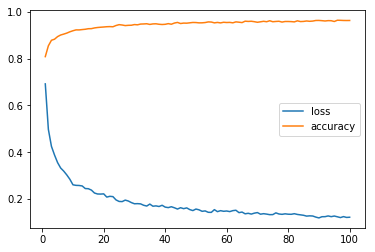

In [9]:
fig, ax = plt.subplots(facecolor='w')
ax.plot(np.arange(1, epochs + 1), history[:, 0], label='loss')
ax.plot(np.arange(1, epochs + 1), history[:, 1], label='accuracy')
ax.legend()
plt.show()

In [10]:
# テストデータに対する精度を算出する。
acc = accuracy.eval(session=sess, feed_dict={x: x_test, t: y_test})
print('accuracy: {:.2%}'.format(acc))

accuracy: 95.85%
